In [1]:
import torch
from utils.sampling_utils import *
import matplotlib.pyplot as plt

/home/rahman79/miniconda3/envs/local_scale/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (None)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(


## Local Scaling

First see the local scaling operation in action on MNIST dataset.

In [2]:
# load the mnist dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 54116649.48it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 1280504.16it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 12641046.75it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 3615587.16it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



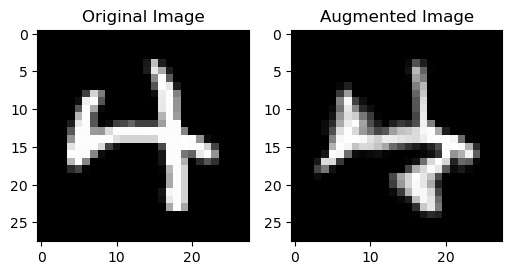

In [12]:
for data in train_loader:
    x, y = data
    param_x = torch.rand(x.shape[0], 8,7) * 0.5
    param_y = torch.rand(y.shape[0], 8,7) * 0.1

    # the defomatioon amount depeends on the variation of the parameters
    # randn is multiplied by 0.15 to get a small variance, thus the deformation is small
    x_augmented = deform(param_x, param_y, x) # this function is defined in the utils/sampling_utils.py file

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(x[0][0].detach().numpy(), cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(x_augmented[0][0].detach().numpy(), cmap='gray')
    axs[1].set_title('Augmented Image')
    plt.show()
    break

## Backbone model
First let us create a two layer CNN, which will act as our backbone model.
In readworld case, this could be pre-trained SwinVit on imagenet.

In [14]:
# create an 2 layered CNN for Mnist
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = torch.nn.Linear(1024, 128)
        self.fc2 = torch.nn.Linear(128, 10)
    
    def forward(self, x):

        # first block
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        # second block
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        # final classifier
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return x

## Cannonicalizer

We will use a deep equilibrium model a our cannonicalizer, which iteratively fed its own output. The following is simple example of DEM. And in this example, we are doing to do adaptation only on the first block of the CNN (backbone) model.

In practive, we will do adaptation in more than 1 block of backbone model and the DEM model will be used each such adaptation. 

In [15]:
class DEM(torch.nn.Module):
    def __init__(self):
        super(DEM, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(32, 2, kernel_size=5)
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((4,3))
    
    def forward(self, x, phi_x, phi_y):
        x = deform(phi_x, phi_y, x)
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = self.avg_pool(x)

        return x[:, 0, :,:], x[:, 1, :,:]
    def _DEM(self, x, phi_x, phi_y):

        out_x, out_y = phi_x.clone(), phi_y.clone()
        for _ in range(10):
            out_x, out_y = self.forward(x.clone(), out_x, out_y)
        
        return out_x, out_y

## Adaptation

In the following, we will demonstrate how to incorporate our proposed adaptation into the backbone CNN model.

In [16]:
class adaCNN(CNN):
    def __init__(self):
        super(adaCNN, self).__init__()
    
    def forward(self,
                x,
                phi_x,
                phi_y):
        
        # deform the input
        x = deform(phi_x, phi_y, x)
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        # undo the deformation
        # this is for demonstration purposes
        # in practice, for classificxation, we do not need to undo the deformation
        # undoing the deformation is required for Segmentation, Depth Estimation, etc.
        x = inv_deform(phi_x, phi_y, x)

        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)

        return x 

In [17]:
# this is initial parameters for the augmentation network
# this corresponds to no deformation or identity transformation
phi_x = torch.ones(1, 4,3).requires_grad_(True).to('cuda:0')
phi_y = torch.ones(1, 4,3).requires_grad_(True).to('cuda:0')

adacnn = adaCNN().to('cuda:0')
dem = DEM().to('cuda:0')

In [ ]:
optimizer = torch.optim.Adam(list(adacnn.parameters()), lr=1e-3)
optimizer_dem = torch.optim.Adam(list(dem.parameters()), lr=1e-3)

for data in train_loader:
    x, y = data
    # zero the gradients
    optimizer.zero_grad()
    optimizer_dem.zero_grad()

    # repeat the parameters for each image in the batch
    phi_x_batch, phi_y_batch = phi_x.repeat(x.shape[0], 1, 1), phi_y.repeat(x.shape[0], 1, 1)

    # canonicalizated parameters
    phi_x_can, phi_y_can = dem._DEM(x.to('cuda:0'), phi_x_batch, phi_y_batch)

    out = adacnn(x.to('cuda:0'), phi_x_can, phi_y_can)

    loss = torch.nn.CrossEntropyLoss()(out, y.to('cuda:0'))

    loss.backward()
    optimizer.step()
    optimizer_dem.step()

    print("out shape", out.shape)
    print("loss", loss.item())
